## ARIMA
[Chapter 9 ARIMA models](https://otexts.com/fpp3/arima.html)

Exponential Smoothing modesl are based the trend and seasonal components of a time series. ARIMA models describe the autocorrelations 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Set Up Data

In [2]:
#parse datetime with weird timezone format
def parse_datetime_with_timezone(dt_str):
    datetime_str = dt_str[:-3] + dt_str[-2:]
    return pd.to_datetime(datetime_str, utc=True, format="%Y-%m-%d %H:%M:%S%z")

# TODO RE-Write without using "date_parser"
df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')

# Make sure this is the right timezone 
df.index = df.index.tz_convert('America/New_York')

#Set the frequency
#we need to do this before using in STL 
df= df.asfreq(freq='h')

/var/folders/n9/fmlq1lnj2f7d297hfrdwxdb80000gn/T/ipykernel_12329/1879699630.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')


In [3]:
df.drop(columns=["KCPLIATANUNIAT2","KCPLLACYGNEUNLAC2","SECI.KCPS.CIMARRON", "WR.LEC.4", "WR.JEC.2", "WR.JEC.3", "SECI.KCPS.CIMARRON"], inplace=True)

only work with one price node

In [4]:
cimarron=df[["SECI_CIMARRON"]]

#Hold back last week as test set
cimarron_train = cimarron.iloc[:-168]
cimarron_test = cimarron.iloc[-168:]

### Stationarity and Differencing Time Series
* A stationary time series will have the same joint probability density function across any time window
* The data will have the same histogram for any section of the time series
* No-trend, no-seasonaility, constant variance/heteroscedasticitic (the variance of the data does not change over time)
* Befor we start ARIMA modeling we want to make the data stationary
* Transformations help stabalizes the variance
* We also need to stabalize the mean by differencing

### General ARIMA Workflow/Pipelline
1. make data stationary
2. build our model(s)
3. reverse everything (integrating)
4. generate forecasts

### Differencing
* method to make non-stationary time series stationary
* compute the differences between consecutive observations
* helps stabalize the mean
* removes changes in the level of a time series

### AFC and Stationary
* stationary time series the AFC will quickly drop to zero
* non-stationary data the AFC decreases slowly and has a large r1 value

(0.0, 48.0)

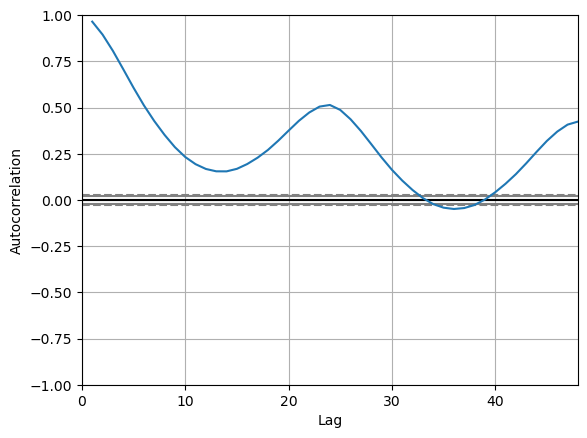

In [6]:
# Let's use pandas this time for auto correlation
pd.plotting.autocorrelation_plot(cimarron_train).set_xlim(0,48)

In [10]:
# comapre this to white noise
from random import gauss

(0.0, 48.0)

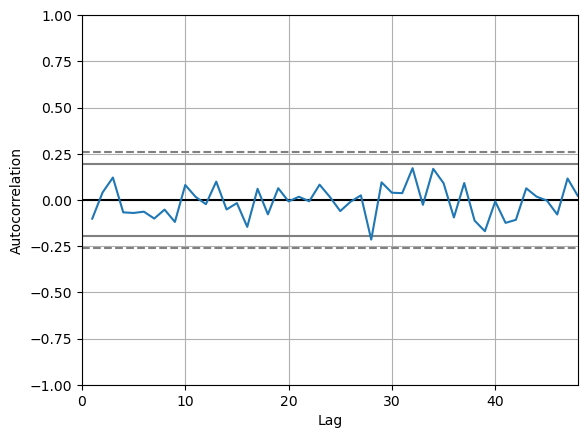

In [13]:
noise = [gauss(0.0, 10.0) for i in range (100)]
noise_sr = pd.Series(noise)
pd.plotting.autocorrelation_plot(noise_sr).set_xlim(0,48)

Prices for Cimarron at non - stationary

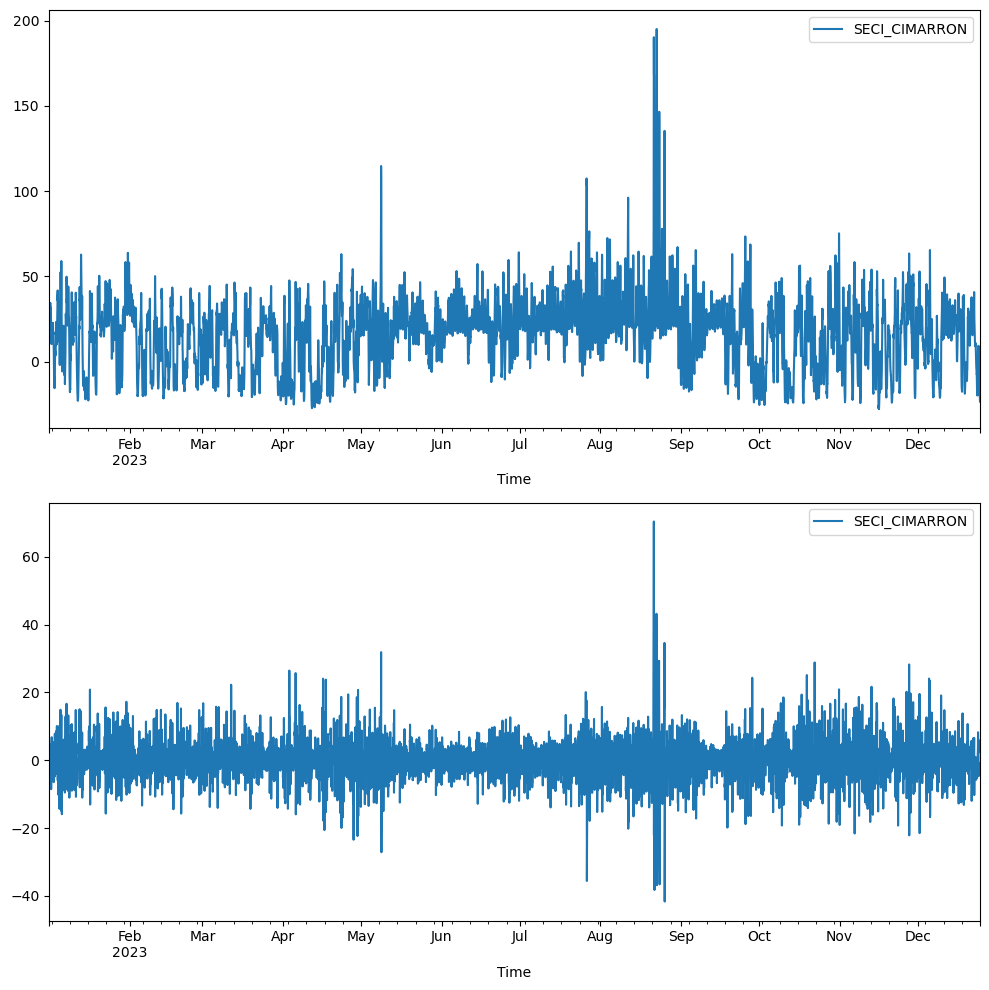

In [20]:
cimarron_diff = cimarron_train.diff()
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
cimarron_train.plot(ax=ax[0])
cimarron_diff.plot(ax=ax[1])
plt.tight_layout()

(0.0, 48.0)

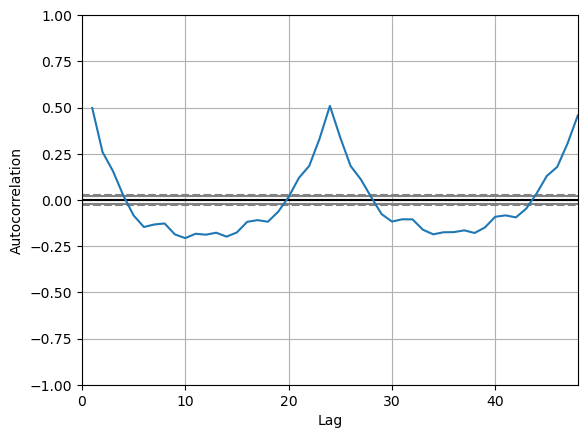

In [25]:
pd.plotting.autocorrelation_plot(cimarron_diff[1:]).set_xlim(0,48)

The differenced time series AFC shows it is less non-stationary than the original time series, but we can still see the strong daily trend in the series. The autocorrelation peaks at the 24 hour and 48 hour marks implying there is a strong linear relationship in the daily trend

### Random Walk Model
if the differenced series is white noise, then we can model the orginal series as
$$ y_t - y_{t-1} = \epsilon_t $$
so we can re-arrange to the "random walk" model
$$ y_t = y_{t-1} + \epsilon_t $$

This model is commonly used in financial and economic data which tends to be non-stationary
random walk model underpins naive forecasts

A related model is the drift method. It allows the model to tend upwards or downwards by allowing the differences to have a non-zero mean
$$ y_t - y_{t-1} = c+\epsilon_t $$ or $$ y_t = c+ y_{t-1}+\epsilon_t $$

### Second - order differencing